Creating the tfrecord_idx file should be done only once in the course of normal operation.

In [1]:
from subprocess import call
import os.path

tfrecord = "/data/imagenet/train-val-tfrecord-480/train-00001-of-01024"
tfrecord_idx = "/opt/ndll/idx_files/train-00001-of-01024.idx"
tfrecord2idx_script = "/opt/ndll/tools/tfrecord2idx.py"

if not os.path.isfile(tfrecord_idx):
    call(["python", tfrecord2idx_script, tfrecord, tfrecord_idx])

In [ ]:
from ndll.pipeline import Pipeline
import ndll.ops as ops
import ndll.types as types
import ndll.tfrecord as tfrec
import numpy as np
from timeit import default_timer as timer
import numpy as np
import matplotlib.pyplot as plt


class HybridPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id):
        super(HybridPipe, self).__init__(batch_size,
                                         num_threads,
                                         device_id)
        self.input = ops.TFRecordReader(path = tfrecord, 
                                        index_path = tfrecord_idx,
                                        features = {"image/encoded" :         tfrec.FixedLenFeature((), tfrec.string, ""),
                                         'image/class/label':      tfrec.FixedLenFeature([1], tfrec.int64,  -1),
                                         'image/class/text':       tfrec.FixedLenFeature([ ], tfrec.string, ''),
                                         'image/object/bbox/xmin': tfrec.VarLenFeature(tfrec.float32, 0.0),
                                         'image/object/bbox/ymin': tfrec.VarLenFeature(tfrec.float32, 0.0),
                                         'image/object/bbox/xmax': tfrec.VarLenFeature(tfrec.float32, 0.0),
                                         'image/object/bbox/ymax': tfrec.VarLenFeature(tfrec.float32, 0.0)})
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
        self.resize = ops.Resize(device = "gpu", random_resize = True,
                                 resize_a = 256, resize_b = 480,
                                 image_type = types.RGB,
                                 interp_type = types.INTERP_LINEAR)
        self.cmnp = ops.CropMirrorNormalize(device = "gpu",
                                            output_dtype = types.FLOAT,
                                            crop = (224, 224),
                                            image_type = types.RGB,
                                            mean = [128., 128., 128.],
                                            std = [1., 1., 1.])
        self.iter = 0

    def define_graph(self):
        inputs = self.input(name="Reader")
        images = self.decode(inputs["image/encoded"])
        images = self.resize(images)
        output = self.cmnp(images)
        return (output, inputs["image/class/label"], inputs["image/class/text"])

    def iter_setup(self):
        pass

In [2]:
pipe = HybridPipe(batch_size=128, num_threads=4, device_id = 0)
pipe2 = Pipeline(128, 4, 0)

In [3]:
s = pipe.serialize()

In [4]:
pipe2.deserialize_and_build(s)

In [5]:
pipe_out = pipe2.run()

radio telescope, radio reflector
radio telescope, radio reflector


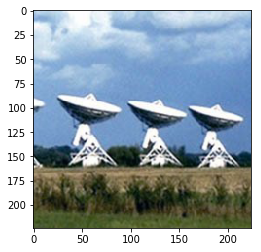

In [6]:
n = 67
from synsets import imagenet_synsets
pipe_out_cpu = pipe_out[0].asCPU()
img_chw = pipe_out_cpu.at(n)
%matplotlib inline
plt.imshow((np.transpose(img_chw, (1,2,0))+128)/255.0)
print(imagenet_synsets[pipe_out[1].at(n)[0]-1])
a = pipe_out[2].at(n)
print("".join([chr(item) for item in a]))

In [7]:
pipe2.epoch_size("Reader")

1252